1. Medical Insurance Costs 예측 모형 Medical Insurance Costs 데이터셋은 개인의 의료비 청구액을 예측하는 데 사용될 수 있는 데이터셋이다.

- 데이터 소스 : https://raw.githubusercontent.com/aonekoda/reference/refs/heads/main/data/insuranc e.csv

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, classification_report, confusion_matrix


In [4]:
# Data Load and check shapes
df = pd.read_csv("https://raw.githubusercontent.com/aonekoda/reference/refs/heads/main/data/insurance.csv")

In [ ]:
df.info() # There is no NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.head() # 연속형 변수와 이산형 변수로 나뉘어져 있음을 확인할 수 있고, 종속변수는 charges

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


=== Statistics ===
count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

=== Distributions Shape===
Skewness: 1.5159
Kurtosis: 1.6063


Text(0.5, 0, 'Charges')

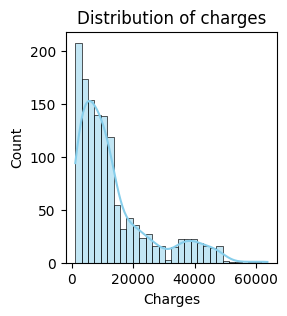

In [27]:
# Basic Statistics print
print("=== Statistics ===")
print(df['charges'].describe())

print("\n=== Distributions Shape===")
print(f"Skewness: {df['charges'].skew():.4f}")
print(f"Kurtosis: {df['charges'].kurt():.4f}")

# Check distributions of charges
plt.figure(figsize=(6, 3))

plt.subplot(1,2,1)
sns.histplot(df['charges'], kde=True, color='skyblue')
plt.title('Distribution of charges')
plt.xlabel('Charges')


=== 상관계수 행렬 (Correlation Matrix) ===
children    0.067998
bmi         0.198341
age         0.299008
charges     1.000000
Name: charges, dtype: float64


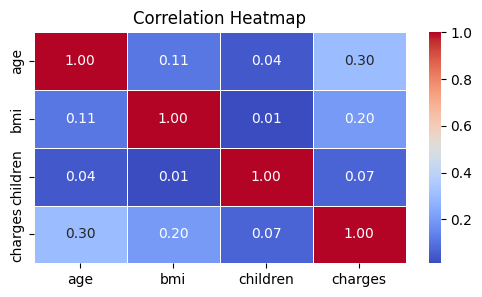

In [28]:
# --- Step1-1. 연속형 독립변수의 상관관계 분석 --- #
numeric_df = df.select_dtypes(include=['number'])

# Correlation matrix
corr_matrix = numeric_df.corr()

print("=== 상관계수 행렬 (Correlation Matrix) ===")
print(corr_matrix['charges'].sort_values(ascending=True))

# Heat map visualization
plt.figure(figsize=(6,3))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_5008\2567330092.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='charges', data=df, ax=axes[i], palette='Set2')
C:\Users\User\AppData\Local\Temp\ipykernel_5008\2567330092.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='charges', data=df, ax=axes[i], palette='Set2')
C:\Users\User\AppData\Local\Temp\ipykernel_5008\2567330092.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='charges', data=df, ax=axes[i], palette='Set2')


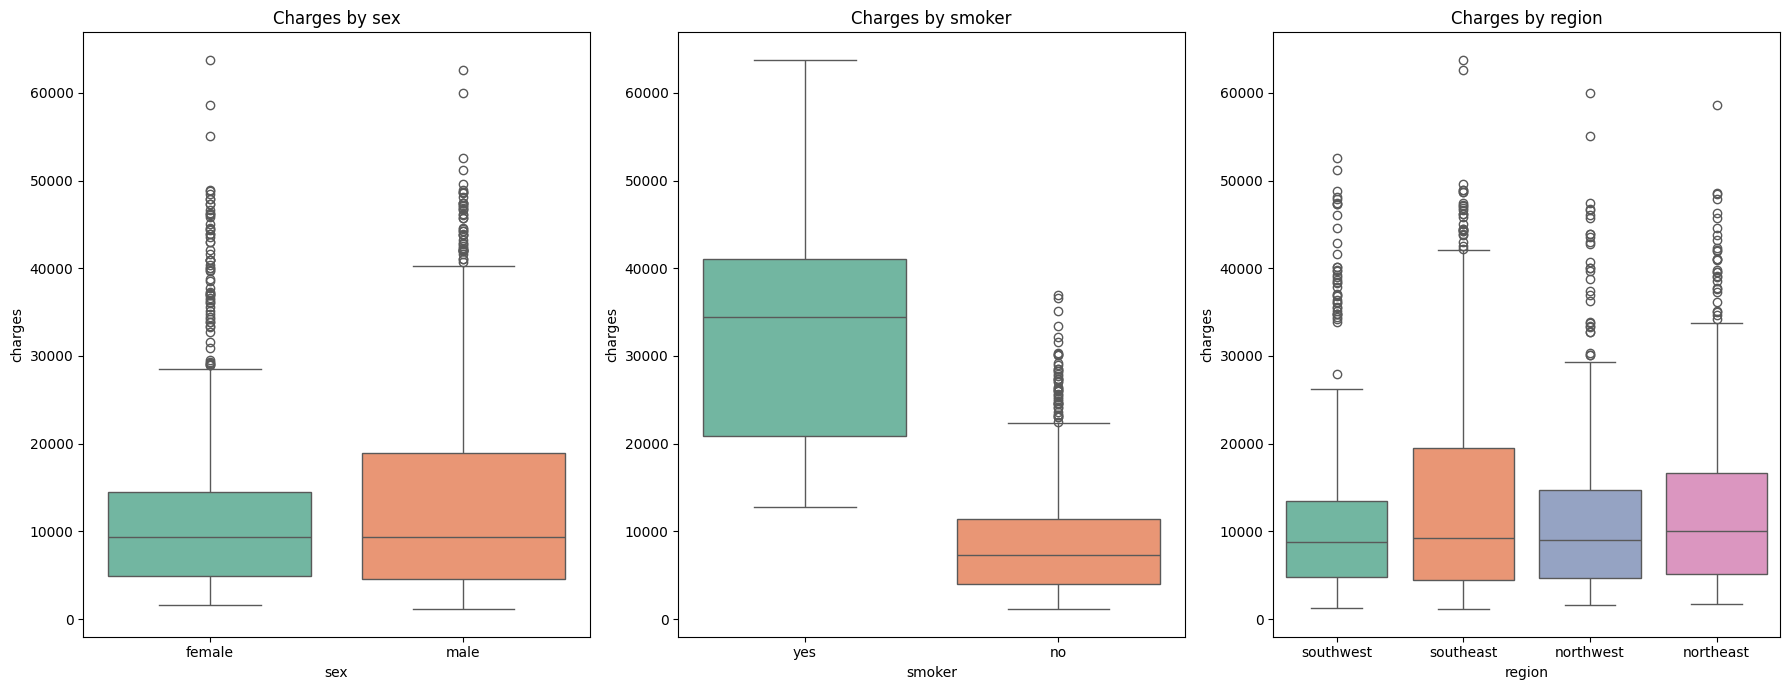

In [ ]:
# --- Step1-2. 범주형 변수 분석 (Categorical data Analysis) --- #
categorical_cols = ['sex', 'smoker', 'region']

# sub plot 1x3
fig, axes = plt.subplots(1, 3, figsize = (18, 7))

for i, col in enumerate(categorical_cols):
    # 각 범주별 charges 분포를 Boxplot으로 시각화
    sns.boxplot(x=col, y='charges', data=df, ax=axes[i], palette='Set2')
    axes[i].set_title(f"Charges by {col}")

plt.tight_layout()
plt.show()


# 흡연자와 비흡연자의 의료비 지출에 유의차가 있어 상관관계가 가장 높은것으로 해석 됨.

In [34]:
# --- Step2. 데이터 전처리 (Preprocessing) --- #

# --- Step2-1. 데이터 분할 (Features & Target) --- #
X = df.drop('charges', axis=1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# --- Step2-2. 데이터 전처리 파이프라인 구축 (make_pipelines) --- #
# 연속형 변수와 이산형 변수 리스트 정의
continuous_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

# 연속형 변수 사용할 파이프 라인 : StandardScaler
continuous_transformer = make_pipeline(StandardScaler())

# 이산형 변수 사용할 파이프 라인 : one-hot encoder
categorical_transformer = make_pipeline(OneHotEncoder(drop='first', handle_unknown='ignore'))
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, continuous_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# --- Step2-3. Data 전처리 진행 --- #
# Preprocessing applied
X_train_processed = preprocessor.fit_transform(X_train)
print("=== make_pipeline을 이용한 전처리 완료 ===")
print(f"연속형 변수 개수: {len(continuous_features)}")
print(f"범주형 변수 개수: {len(categorical_features)}")
print(f"최종 변환된 Feature 개수: {X_train_processed.shape[1]}")

=== make_pipeline을 이용한 전처리 완료 ===
연속형 변수 개수: 3
범주형 변수 개수: 3
최종 변환된 Feature 개수: 8


In [ ]:
# --- Step3. 회귀 모델 평가 --- #
import joblib # 모델 저장위한 라이브러리

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [40]:
# --- Step3-1. 사용할 모델 리스트 정의 --- #
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
]

# 결과 저장할 리스트
results = []
best_score = -np.inf # 가장 높은 R2 Score를 찾기 위한 초기화
best_model_pipeline = None
best_model_name = ""

In [42]:
# ---Step3-2. 모델 학습 및 평가 Loop --- #
print("=== 모델링 및 성능 평가 시작 ===")

for name, model in models:
    # 전처리기와 모델을 연결한 전체 파이프라인 생성 (make_pipeline 사용)
    # 데이터 흐름: Raw Data -> preprocessor(전처리) -> model(학습/예측)
    pipeline = make_pipeline(preprocessor, model)

    # 학습 (Fitting)
    pipeline.fit(X_train, y_train)

    # 예측 (Prediction)
    y_pred = pipeline.predict(X_test)

    # 평가 (Evaluation)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # 결과 저장
    results.append([name, r2, rmse])
    print(f"[{name} R2: {r2:.4f}, RMSE: {rmse:.4f}]")

    # 최적 모델 선정 (R2 score 기준)

    if r2 > best_score:
        best_score = r2
        best_model_pipeline = pipeline # 파이프라인 전체를 저장
        best_model_name = name

# 평가 결과를 DataFrame으로 정리
results_df = pd.DataFrame(results, columns=['Model', 'R2', 'RMSE'])

print("\n=== 전체 모델 성능 비교 (Score 내림차순) ===")
print(results_df)

print(f"\n=== 최적 모델 선정 결과 ===")
print(f"Best Model: {best_model_name}")
print(f"Best R2 Score: {best_score:.4f}")

=== 모델링 및 성능 평가 시작 ===
[Linear Regression R2: 0.7836, RMSE: 5796.2847]
[Ridge R2: 0.7833, RMSE: 5800.4649]
[Lasso R2: 0.7835, RMSE: 5797.0448]
[Decision Tree R2: 0.7372, RMSE: 6387.1225]
[Gradient Boosting R2: 0.8793, RMSE: 4329.5700]
[XGBoost R2: 0.8686, RMSE: 4517.2856]

=== 전체 모델 성능 비교 (Score 내림차순) ===
               Model        R2         RMSE
0  Linear Regression  0.783593  5796.284659
1              Ridge  0.783281  5800.464938
2              Lasso  0.783536  5797.044759
3      Decision Tree  0.737226  6387.122471
4  Gradient Boosting  0.879257  4329.570011
5            XGBoost  0.868560  4517.285610

=== 최적 모델 선정 결과 ===
Best Model: Gradient Boosting
Best R2 Score: 0.8793


In [43]:
# --- Step3-4. 최적 모델 저장 (joblib 사용) --- #
save_path = 'best_insurance_model.pkl'
joblib.dump(best_model_pipeline, save_path)
print(f"'{best_model_name}' 모델이 '{save_path}' 파일로 저장되었습니다.")

'Gradient Boosting' 모델이 'best_insurance_model.pkl' 파일로 저장되었습니다.
